exp/local_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250806093443/eval_results.log

exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805215223/eval_results.log

exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805232132/eval_results.log

exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250813145154/eval_results.log

exp/mix_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805223526/eval_results.log

exp/ditto_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250806091735/eval_results.log

exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805232249/eval_results.log

exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/eval_results.log

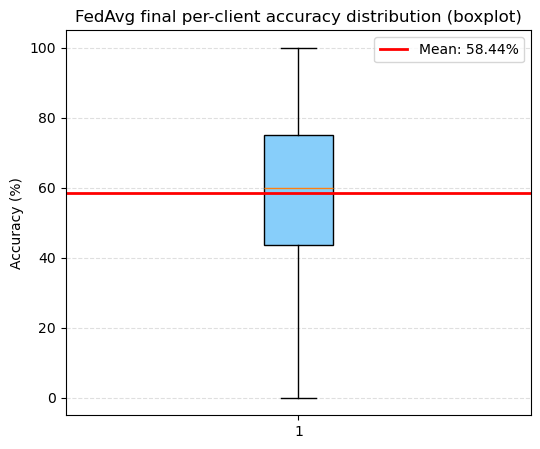

In [1]:
# 解析 eval_results.log 并绘制每客户端最终准确率的箱线图（红线为平均值）
import os
import ast
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 避免中文/全角符号导致的字体缺字警告：统一使用 ASCII 文本
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

# 日志文件路径（优先使用相对路径，若不存在则尝试工作区绝对路径）
rel_path = "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805215223/eval_results.log"
abs_path = os.path.join("/home/liruobin/FL/FederatedScope", rel_path)
log_path = rel_path if os.path.exists(rel_path) else (abs_path if os.path.exists(abs_path) else rel_path)

if not os.path.exists(log_path):
    raise FileNotFoundError(f"Log file not found: {rel_path} or {abs_path}")

# 从一行格式化日志中提取准确率字段（优先 test_acc/acc/accuracy）
def extract_acc_from_line(line: str):
    # 先尝试作为 Python 字面量解析
    metrics_dict = None
    try:
        obj = ast.literal_eval(line.strip())
        # 兼容格式：{'Results_raw': {...}} 或直接 {...}
        if isinstance(obj, dict):
            metrics_dict = obj.get('Results_raw', obj)
    except Exception:
        metrics_dict = None

    # 若字面量失败，尝试正则从文本中抓取 "xxx_acc": number
    if metrics_dict is None:
        # e.g. 'test_acc': 0.9123 或 "test_acc": 0.9123
        m = re.findall(r"['\"]([A-Za-z0-9_]*acc[A-Za-z0-9_]*)['\"]\s*:\s*([0-9]*\.?[0-9]+)", line, flags=re.IGNORECASE)
        if m:
            # 选择包含 'test_acc' 优先
            m_sorted = sorted(m, key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
            return float(m_sorted[0][1])
        return None

    # 在 metrics_dict 中找候选 key
    acc_keys = []
    for k, v in metrics_dict.items():
        if isinstance(v, (int, float)) and ("acc" in k.lower() or "accuracy" in k.lower()):
            acc_keys.append((k, float(v)))
    if not acc_keys:
        return None
    # 优先 test_acc，然后 acc/accuracy
    acc_keys.sort(key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
    return acc_keys[0][1]

# 读取所有行，提取每客户端一次准确率（该文件一般在最终评估时写入一行/客户端）
accs = []
with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        val = extract_acc_from_line(line)
        if val is not None:
            accs.append(val)

if len(accs) == 0:
    raise RuntimeError("No accuracy fields (acc/accuracy) were parsed from the log.")

# 规范化刻度：若最大值>1.5，认为是百分比，否则按 [0,1] 小数；绘图时统一显示为百分比
accs = np.array(accs, dtype=float)
use_percent = accs.max() > 1.5
plot_vals = accs if use_percent else accs * 100.0
mean_val = float(plot_vals.mean())

plt.figure(figsize=(6, 5))
plt.boxplot(plot_vals, vert=True, patch_artist=True, boxprops=dict(facecolor='#87CEFA'))
plt.axhline(mean_val, color='red', linewidth=2, linestyle='-', label=f"Mean: {mean_val:.2f}%")
plt.ylabel("Accuracy (%)")
plt.title("FedAvg final per-client accuracy distribution (boxplot)")
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


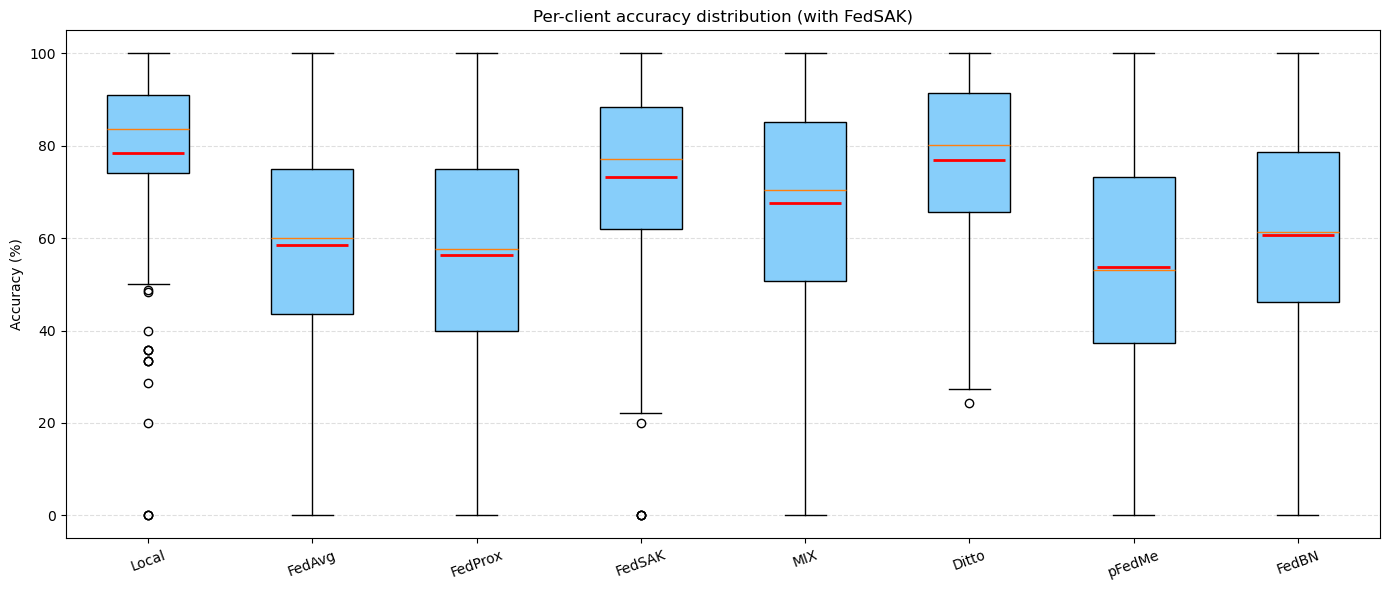

In [2]:
# Compare multiple methods (include FedSAK): multi-boxplot with per-box mean line
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate log files from the notebook header (now include FedSAK)
log_paths = [
    "exp/local_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250806093443/eval_results.log",
    "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805215223/eval_results.log",
    "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805232132/eval_results.log",
    "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250813145154/eval_results.log",
    "exp/mix_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805223526/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250806091735/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/sub_exp_20250805232249/eval_results.log",
    "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.1_lstep1/eval_results.log",
]

# Helper: resolve path

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Helper: label from path

def label_from_path(p):
    # pick the first folder under exp/ as method label
    m = re.search(r"exp/([^/_]+)", p)
    if m:
        label = m.group(1)
    else:
        # fallback to folder name
        label = os.path.basename(os.path.dirname(p))
    # normalize common names for readability
    alias = {
        'FedAvg': 'FedAvg',
        'fedprox': 'FedProx',
        'mix': 'MIX',
        'ditto': 'Ditto',
        'pfedme': 'pFedMe',
        'fedbn': 'FedBN',
        'local': 'Local',
        'fedsak': 'FedSAK',
    }
    # map by lowercase key if matched
    key = label.lower()
    for k, v in alias.items():
        if key == k:
            return v
    # Title-case fallback
    return label

# Helper: extract accuracy from a line

def extract_acc_from_line(line: str):
    try:
        obj = ast.literal_eval(line.strip())
        if isinstance(obj, dict):
            metrics = obj.get('Results_raw', obj)
        else:
            metrics = None
    except Exception:
        metrics = None
    if metrics is None:
        m = re.findall(r"['\"]([A-Za-z0-9_]*acc[A-Za-z0-9_]*)['\"]\s*:\s*([0-9]*\.?[0-9]+)", line, flags=re.IGNORECASE)
        if m:
            m_sorted = sorted(m, key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
            return float(m_sorted[0][1])
        return None
    acc_keys = []
    for k, v in metrics.items():
        if isinstance(v, (int, float)) and ("acc" in k.lower() or "accuracy" in k.lower()):
            acc_keys.append((k, float(v)))
    if not acc_keys:
        return None
    acc_keys.sort(key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
    return acc_keys[0][1]

# Load all logs
method_labels = []
method_values = []  # list of np.array (percent values)

for rel in log_paths:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    vals = []
    with open(rp, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            v = extract_acc_from_line(line)
            if v is not None:
                vals.append(v)
    if len(vals) == 0:
        print(f"Skip (no acc parsed): {rel}")
        continue
    arr = np.array(vals, dtype=float)
    # unify to percent for plotting
    arr = arr if arr.max() > 1.5 else arr * 100.0
    method_labels.append(label_from_path(rel))
    method_values.append(arr)

if len(method_values) == 0:
    raise RuntimeError("No valid logs found to plot.")

# Plot multi-boxplot
plt.figure(figsize=(1.2 + 1.6*len(method_values), 6))
positions = np.arange(1, len(method_values)+1)
plt.boxplot(method_values, positions=positions, widths=0.5, vert=True,
            patch_artist=True, boxprops=dict(facecolor='#87CEFA'))
plt.ylabel("Accuracy (%)")
plt.title("Per-client accuracy distribution (with FedSAK)")
plt.xticks(positions, method_labels, rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Draw a red mean line inside each box
for x, arr in zip(positions, method_values):
    mean_val = float(arr.mean())
    plt.hlines(mean_val, x-0.22, x+0.22, colors='red', linewidth=2)

plt.tight_layout()
plt.show()


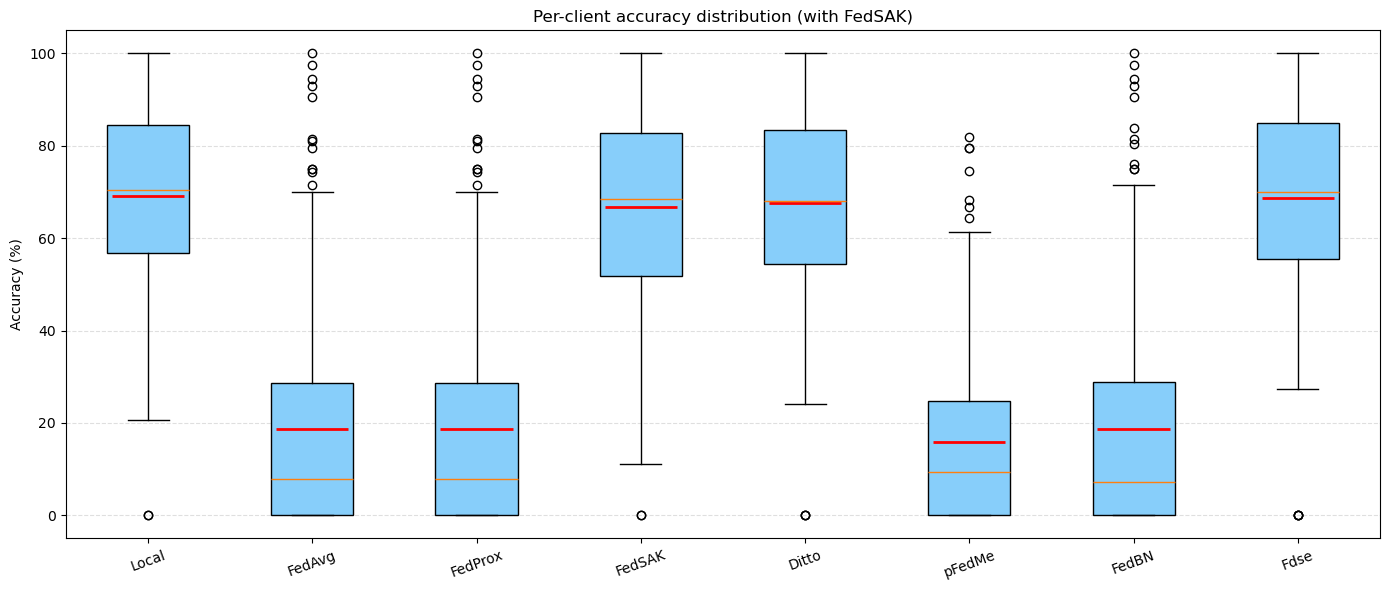

In [2]:
# Compare multiple methods (include FedSAK): multi-boxplot with per-box mean line
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate log files from the notebook header (now include FedSAK)
log_paths = [
    "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Helper: resolve path

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Helper: label from path

def label_from_path(p):
    # pick the first folder under exp/ as method label
    m = re.search(r"exp/([^/_]+)", p)
    if m:
        label = m.group(1)
    else:
        # fallback to folder name
        label = os.path.basename(os.path.dirname(p))
    # normalize common names for readability
    alias = {
        'FedAvg': 'FedAvg',
        'fedprox': 'FedProx',
        'ditto': 'Ditto',
        'pfedme': 'pFedMe',
        'fedbn': 'FedBN',
        'local': 'Local',
        'fedsak': 'FedSAK',
        'fdse': 'Fdse'
    }
    # map by lowercase key if matched
    key = label.lower()
    for k, v in alias.items():
        if key == k:
            return v
    # Title-case fallback
    return label

# Helper: extract accuracy from a line

def extract_acc_from_line(line: str):
    try:
        obj = ast.literal_eval(line.strip())
        if isinstance(obj, dict):
            metrics = obj.get('Results_raw', obj)
        else:
            metrics = None
    except Exception:
        metrics = None
    if metrics is None:
        m = re.findall(r"['\"]([A-Za-z0-9_]*acc[A-Za-z0-9_]*)['\"]\s*:\s*([0-9]*\.?[0-9]+)", line, flags=re.IGNORECASE)
        if m:
            m_sorted = sorted(m, key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
            return float(m_sorted[0][1])
        return None
    acc_keys = []
    for k, v in metrics.items():
        if isinstance(v, (int, float)) and ("acc" in k.lower() or "accuracy" in k.lower()):
            acc_keys.append((k, float(v)))
    if not acc_keys:
        return None
    acc_keys.sort(key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
    return acc_keys[0][1]

# Load all logs
method_labels = []
method_values = []  # list of np.array (percent values)

for rel in log_paths:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    vals = []
    with open(rp, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            v = extract_acc_from_line(line)
            if v is not None:
                vals.append(v)
    if len(vals) == 0:
        print(f"Skip (no acc parsed): {rel}")
        continue
    arr = np.array(vals, dtype=float)
    # unify to percent for plotting
    arr = arr if arr.max() > 1.5 else arr * 100.0
    method_labels.append(label_from_path(rel))
    method_values.append(arr)

if len(method_values) == 0:
    raise RuntimeError("No valid logs found to plot.")

# Plot multi-boxplot
plt.figure(figsize=(1.2 + 1.6*len(method_values), 6))
positions = np.arange(1, len(method_values)+1)
plt.boxplot(method_values, positions=positions, widths=0.5, vert=True,
            patch_artist=True, boxprops=dict(facecolor='#87CEFA'))
plt.ylabel("Accuracy (%)")
plt.title("Per-client accuracy distribution (with FedSAK)")
plt.xticks(positions, method_labels, rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Draw a red mean line inside each box
for x, arr in zip(positions, method_values):
    mean_val = float(arr.mean())
    plt.hlines(mean_val, x-0.22, x+0.22, colors='red', linewidth=2)

plt.tight_layout()
plt.show()


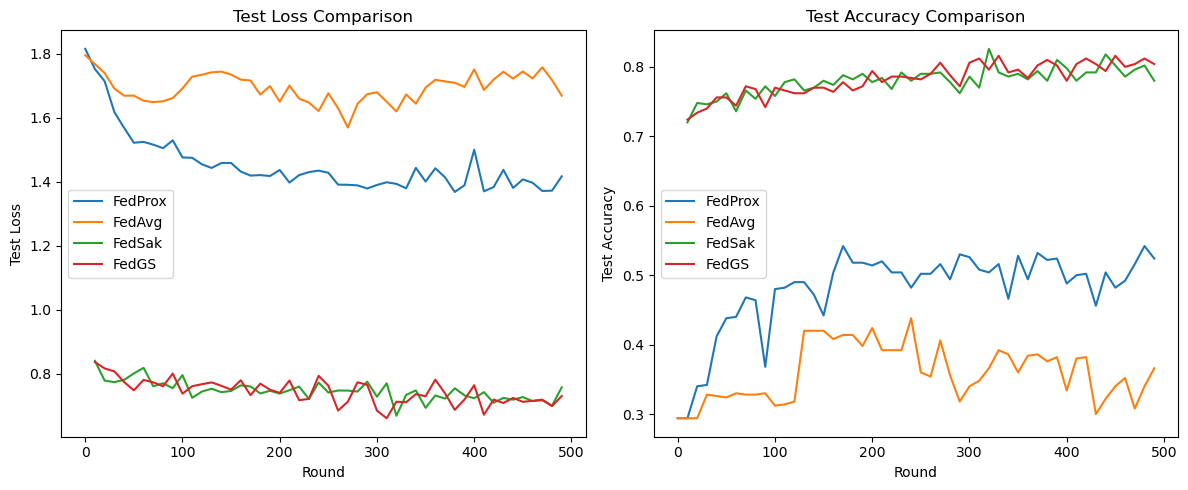

In [14]:
import ast
import matplotlib.pyplot as plt

def load_data(log_file, freq=1):
    rounds = []
    test_losses = []
    test_accs = []
    with open(log_file, 'r', encoding='utf8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                record = ast.literal_eval(line)
                # 只处理 Role 为 "Server #" 且 Round 为整数的记录
                if record.get('Role') == 'Server #' and isinstance(record.get('Round'), int):
                    round_num = record['Round']
                    if round_num % freq != 0:
                        continue  # 跳过不需要的轮次
                    results = record.get('Results_weighted_avg', {})
                    if 'test_avg_loss' in results and 'test_acc' in results:
                        rounds.append(round_num)
                        test_losses.append(results['test_avg_loss'])
                        test_accs.append(results['test_acc'])
            except Exception as e:
                continue
    return rounds, test_losses, test_accs

# 加载 FedProx, FedAvg 和 FesSak 的日志数据
fedprox_log = 'fedprox_rnn_on_ut_har_lr0.0005_lstep5/sub_exp_20250708134016/eval_results.log'
fedavg_log = 'FedAvg_rnn_on_ut_har_lr0.0005_lstep5/sub_exp_20250708120223/eval_results.log'
fedsak_log = 'fedsak_rnn_on_ut_har_lr0.0005_lstep5/sub_exp_20250708142047/eval_results.log'
fedgs_log = 'fedgs_rnn_on_ut_har_lr0.0005_lstep5/sub_exp_20250711165502/eval_results.log'

# 设置画图频率
freq = 10

# 加载日志数据时传入freq参数
rounds_prox, losses_prox, accs_prox = load_data(fedprox_log, freq)
rounds_avg,  losses_avg,  accs_avg  = load_data(fedavg_log, freq)
rounds_sak,  losses_sak,  accs_sak  = load_data(fedsak_log, freq)
rounds_gs,   losses_gs,   accs_gs   = load_data(fedgs_log, freq)

# 创建一个包含1行2列的图表
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 左侧子图：Test Loss 对比
axs[0].plot(rounds_prox, losses_prox, label='FedProx')
axs[0].plot(rounds_avg, losses_avg, label='FedAvg')
axs[0].plot(rounds_sak, losses_sak, label='FedSak')
axs[0].plot(rounds_gs, losses_gs, label='FedGS')
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Test Loss")
axs[0].set_title("Test Loss Comparison")
axs[0].legend()

# 右侧子图：Test Accuracy 对比
axs[1].plot(rounds_prox, accs_prox, label='FedProx')
axs[1].plot(rounds_avg, accs_avg, label='FedAvg')
axs[1].plot(rounds_sak, accs_sak, label='FedSak')
axs[1].plot(rounds_gs, accs_gs, label='FedGS')
axs[1].set_xlabel("Round")
axs[1].set_ylabel("Test Accuracy")
axs[1].set_title("Test Accuracy Comparison")
axs[1].legend()

plt.tight_layout()
plt.show()

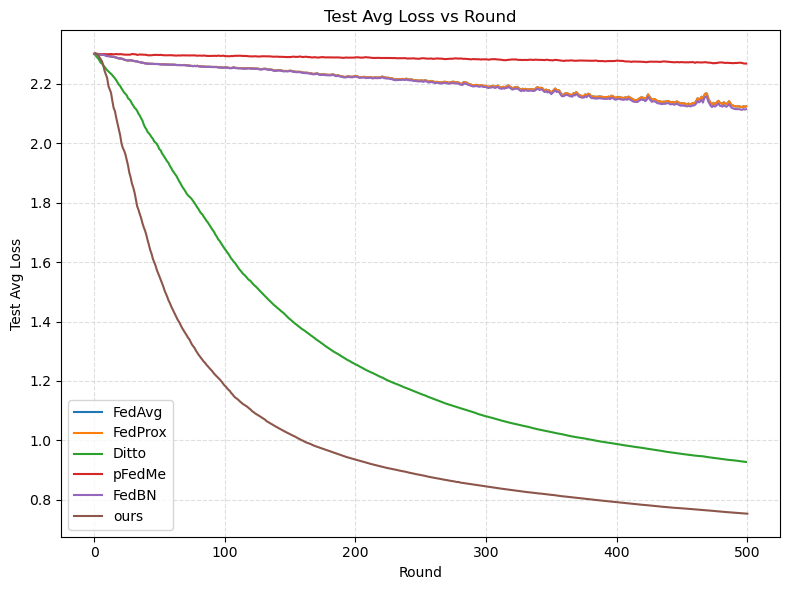

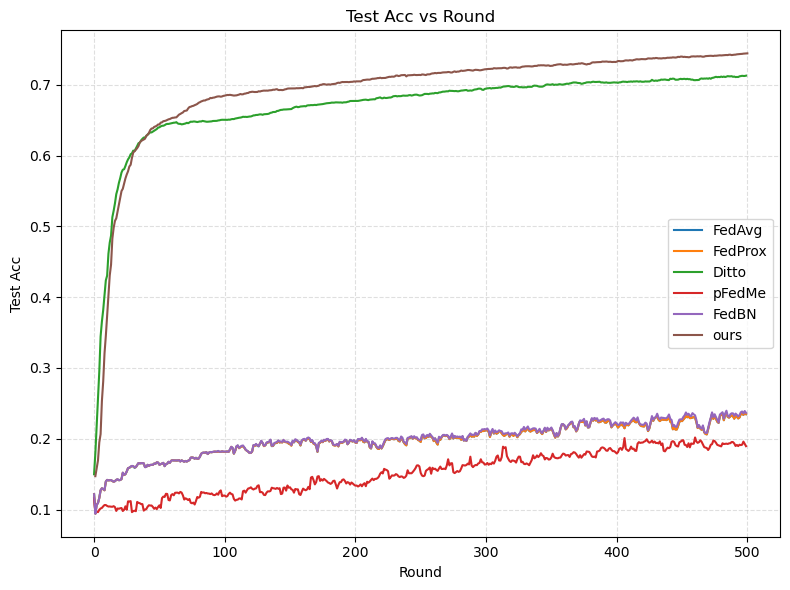

In [10]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'FedSAK',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'ours',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# 创建第一个图：损失曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(losses).any():
        plt.plot(xs, losses, label=label, markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Avg Loss')
plt.title('Test Avg Loss vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 创建第二个图：准确率曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(accs).any():
        plt.plot(xs, accs, label=label,  markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Acc')
plt.title('Test Acc vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Performance Summary:
pFedMe:
  Final Loss: 2.268401
  Min Loss:   2.268401
  Final Acc:  0.189543
  Max Acc:    0.201789
----------------------------------------
ours:
  Final Loss: 0.753142
  Min Loss:   0.753142
  Final Acc:  0.744330
  Max Acc:    0.744330
----------------------------------------

Performance Comparison (vs ours):
Compared to pFedMe:
  Loss: ours is 1.515259 lower (66.80% better)
  Acc:  ours is 0.554786 higher (292.70% better)
----------------------------------------


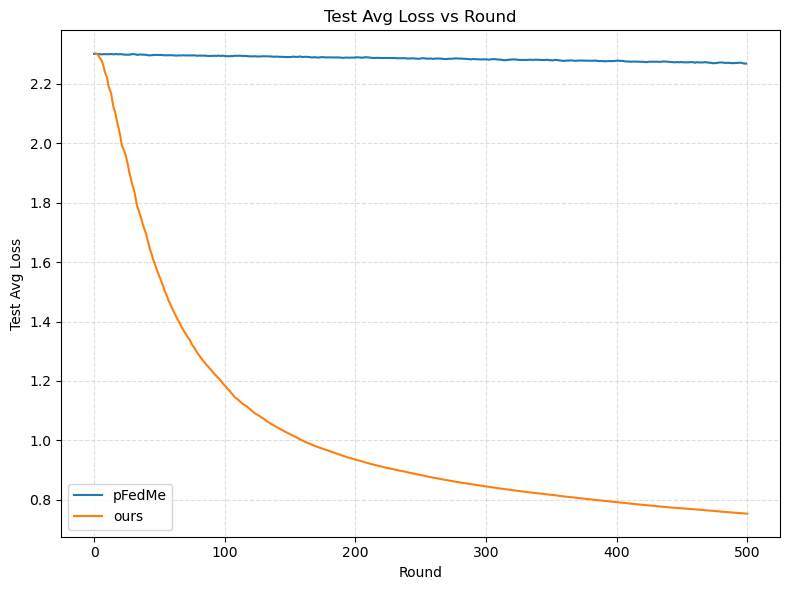

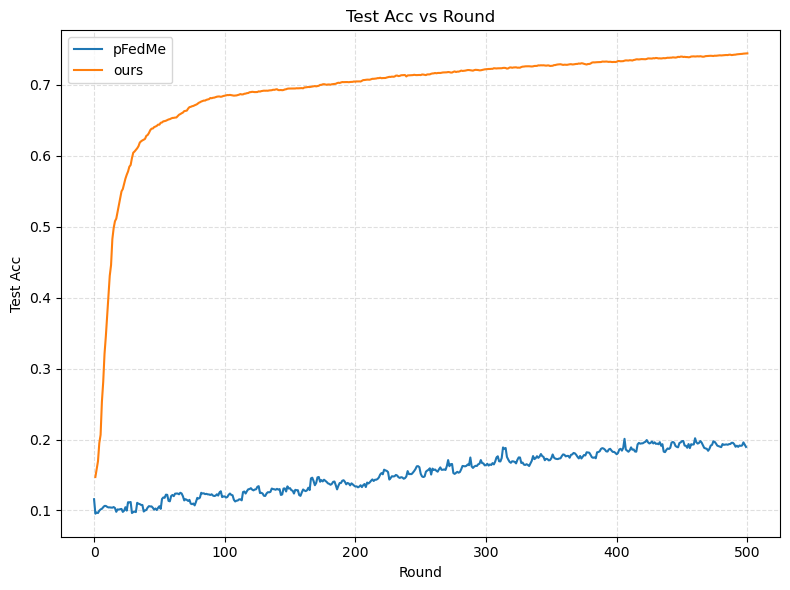

In [9]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    # "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'FedSAK',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'ours',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# 存储所有方法的性能数据
performance_data = {}

# 打印每个方法的最终损失、最低损失、最终准确率、最高准确率
print("=" * 80)
print("Performance Summary:")
print("=" * 80)
for label, xs, losses, accs in curves:
    # 过滤NaN值
    valid_loss_indices = np.isfinite(losses)
    valid_acc_indices = np.isfinite(accs)
    
    if np.any(valid_loss_indices):
        final_loss = losses[valid_loss_indices][-1] if np.any(valid_loss_indices) else np.nan
        min_loss = np.min(losses[valid_loss_indices]) if np.any(valid_loss_indices) else np.nan
    else:
        final_loss = min_loss = np.nan
        
    if np.any(valid_acc_indices):
        final_acc = accs[valid_acc_indices][-1] if np.any(valid_acc_indices) else np.nan
        max_acc = np.max(accs[valid_acc_indices]) if np.any(valid_acc_indices) else np.nan
    else:
        final_acc = max_acc = np.nan
    
    # 存储性能数据
    performance_data[label] = {
        'final_loss': final_loss,
        'min_loss': min_loss,
        'final_acc': final_acc,
        'max_acc': max_acc
    }
    
    print(f"{label}:")
    print(f"  Final Loss: {final_loss:.6f}")
    print(f"  Min Loss:   {min_loss:.6f}")
    print(f"  Final Acc:  {final_acc:.6f}")
    print(f"  Max Acc:    {max_acc:.6f}")
    print("-" * 40)

# 自动对比ours与其他方法
print("\n" + "=" * 80)
print("Performance Comparison (vs ours):")
print("=" * 80)

if 'ours' in performance_data:
    ours_data = performance_data['ours']
    
    for method, data in performance_data.items():
        if method != 'ours' and not np.isnan(data['final_loss']) and not np.isnan(data['final_acc']):
            # 损失对比
            loss_diff = data['final_loss'] - ours_data['final_loss']
            loss_improvement = (loss_diff / data['final_loss']) * 100 if data['final_loss'] != 0 else 0
            
            # 准确率对比
            acc_diff = ours_data['final_acc'] - data['final_acc']
            acc_improvement = (acc_diff / data['final_acc']) * 100 if data['final_acc'] != 0 else 0
            
            print(f"Compared to {method}:")
            if loss_diff < 0:
                print(f"  Loss: ours is {abs(loss_diff):.6f} higher ({abs(loss_improvement):.2f}% worse)")
            else:
                print(f"  Loss: ours is {loss_diff:.6f} lower ({loss_improvement:.2f}% better)")
            
            if acc_diff < 0:
                print(f"  Acc:  ours is {abs(acc_diff):.6f} lower ({abs(acc_improvement):.2f}% worse)")
            else:
                print(f"  Acc:  ours is {acc_diff:.6f} higher ({acc_improvement:.2f}% better)")
            print("-" * 40)
else:
    print("No 'ours' method found for comparison.")

# 创建第一个图：损失曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(losses).any():
        plt.plot(xs, losses, label=label, markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Avg Loss')
plt.title('Test Avg Loss vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 创建第二个图：准确率曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(accs).any():
        plt.plot(xs, accs, label=label,  markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Acc')
plt.title('Test Acc vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

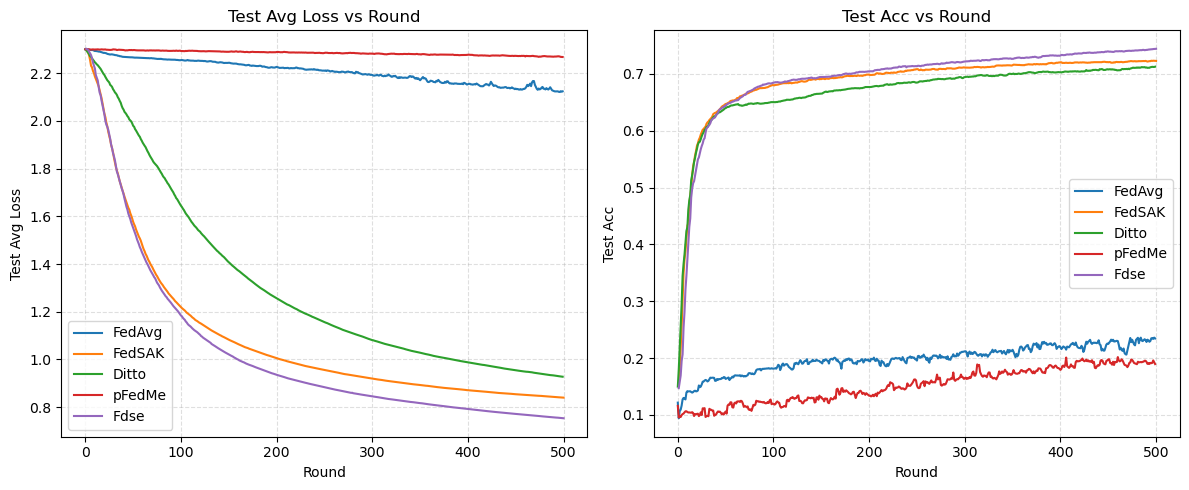

In [10]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'FedSAK',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'Fdse',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# Plotting two subplots: loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for label, xs, losses, accs in curves:
    # Filter NaNs safely for plotting
    if np.isfinite(losses).any():
        axs[0].plot(xs, losses, label=label)
    if np.isfinite(accs).any():
        axs[1].plot(xs, accs, label=label)

axs[0].set_xlabel('Round')
axs[0].set_ylabel('Test Avg Loss')
axs[0].set_title('Test Avg Loss vs Round')
axs[0].grid(True, linestyle='--', alpha=0.4)
axs[0].legend()

axs[1].set_xlabel('Round')
axs[1].set_ylabel('Test Acc')
axs[1].set_title('Test Acc vs Round')
axs[1].grid(True, linestyle='--', alpha=0.4)
axs[1].legend()

plt.tight_layout()
plt.show()

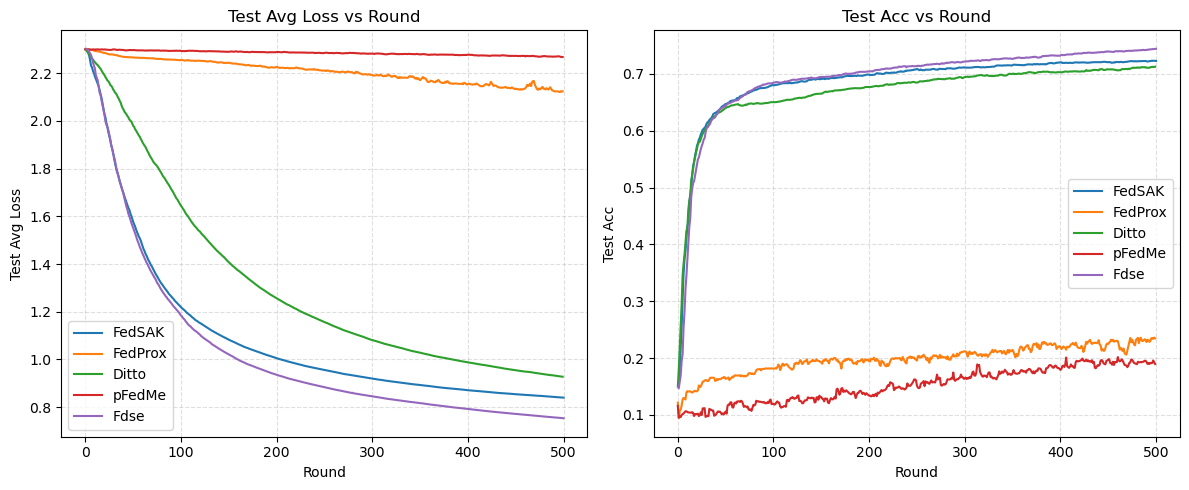

In [9]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    # "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'FedSAK',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'Fdse',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# Plotting two subplots: loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for label, xs, losses, accs in curves:
    # Filter NaNs safely for plotting
    if np.isfinite(losses).any():
        axs[0].plot(xs, losses, label=label)
    if np.isfinite(accs).any():
        axs[1].plot(xs, accs, label=label)

axs[0].set_xlabel('Round')
axs[0].set_ylabel('Test Avg Loss')
axs[0].set_title('Test Avg Loss vs Round')
axs[0].grid(True, linestyle='--', alpha=0.4)
axs[0].legend()

axs[1].set_xlabel('Round')
axs[1].set_ylabel('Test Acc')
axs[1].set_title('Test Acc vs Round')
axs[1].grid(True, linestyle='--', alpha=0.4)
axs[1].legend()

plt.tight_layout()
plt.show()

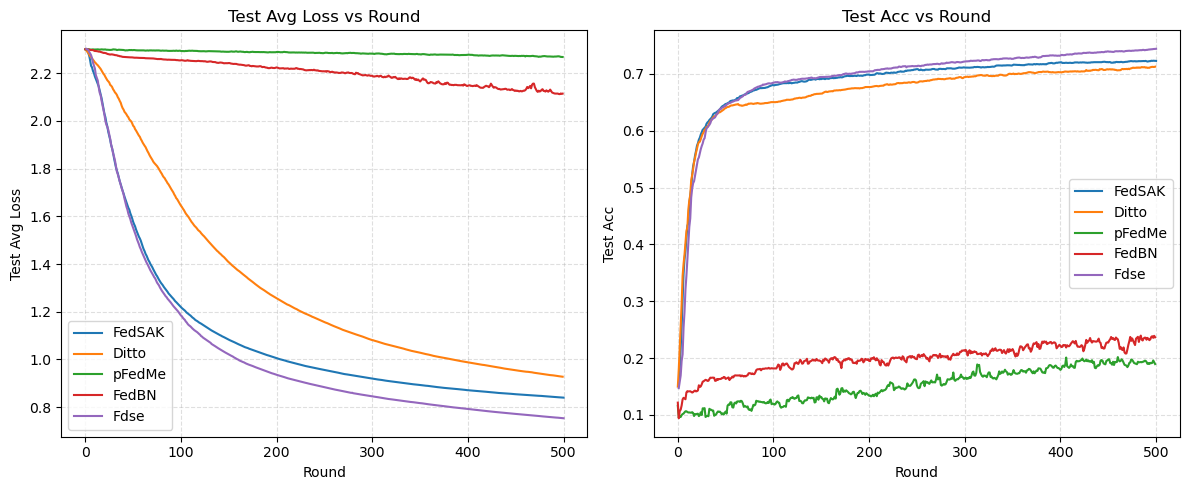

In [13]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    # "exp/FedAvg_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedsak_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fedprox_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/ditto_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820015912/eval_results.log",
    "exp/pfedme_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'FedSAK',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'Fdse',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# Plotting two subplots: loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for label, xs, losses, accs in curves:
    # Filter NaNs safely for plotting
    if np.isfinite(losses).any():
        axs[0].plot(xs, losses, label=label)
    if np.isfinite(accs).any():
        axs[1].plot(xs, accs, label=label)

axs[0].set_xlabel('Round')
axs[0].set_ylabel('Test Avg Loss')
axs[0].set_title('Test Avg Loss vs Round')
axs[0].grid(True, linestyle='--', alpha=0.4)
axs[0].legend()

axs[1].set_xlabel('Round')
axs[1].set_ylabel('Test Acc')
axs[1].set_title('Test Acc vs Round')
axs[1].grid(True, linestyle='--', alpha=0.4)
axs[1].legend()

plt.tight_layout()
plt.show()

exp/FedAvg_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101050/eval_results.log
exp/fedsak_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101102/eval_results.log
exp/fedprox_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log
exp/ditto_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log
exp/pfedme_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806114835/eval_results.log


Performance Summary:
ours:
  Final Loss: 1.033206
  Min Loss:   0.888603
  Final Acc:  0.716000
  Max Acc:    0.770500
----------------------------------------


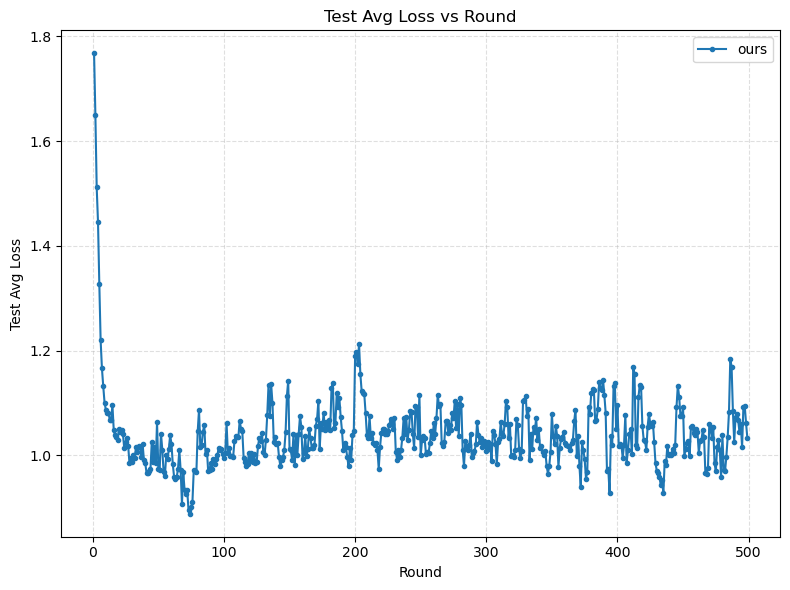

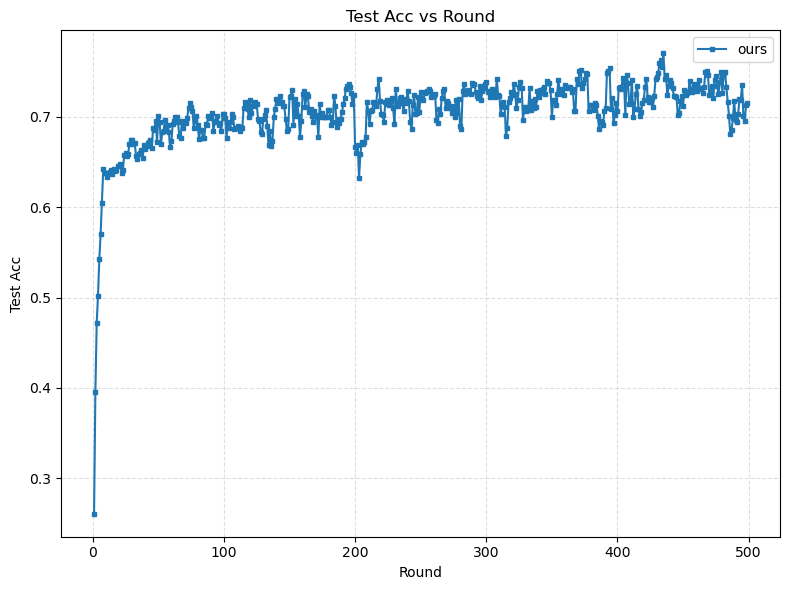

In [4]:
# Parse eval_results.log from multiple methods and plot test_acc & test_avg_loss curves
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate methods and their latest logs (edit if needed)
log_candidates = [
    # "exp/FedAvg_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101050/eval_results.log",
    "exp/fedsak_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101102/eval_results.log",
    # "exp/fedprox_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log",
    # "exp/ditto_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250820123152/eval_results.log",
    # "exp/pfedme_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806114835/eval_results.log",
    
    # "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    # "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Label normalizer from path
_alias = {
    'fedavg': 'FedAvg',
    'fedsak': 'ours',
    'fedprox': 'FedProx',
    'ditto': 'Ditto',
    'pfedme': 'pFedMe',
    'fedbn': 'FedBN',
    'local': 'Local',
    'fdse': 'Fdse',
}

def label_from_path(p):
    m = re.search(r"exp/([^/_]+)", p)
    label = m.group(1) if m else os.path.basename(os.path.dirname(p))
    key = label.lower()
    return _alias.get(key, label)

# Resolve relative/absolute

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Extract round, test_avg_loss, test_acc from a log line if it's a server aggregation record

def parse_server_line(line):
    try:
        obj = ast.literal_eval(line.strip())
    except Exception:
        return None
    if not isinstance(obj, dict):
        return None
    if obj.get('Role') != 'Server #' or not isinstance(obj.get('Round'), int):
        return None
    round_id = obj['Round']
    # Prefer Results_weighted_avg; fallback to Results_raw
    metrics = obj.get('Results_weighted_avg') or obj.get('Results_raw') or obj
    if not isinstance(metrics, dict):
        return None
    loss = metrics.get('test_avg_loss')
    acc = metrics.get('test_acc') or metrics.get('accuracy') or metrics.get('acc')
    if loss is None and acc is None:
        return None
    return round_id, loss, acc

# Load a log into dict: round -> (loss, acc)

def load_curve(log_path):
    rounds = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_server_line(line)
            if parsed is None:
                continue
            r, loss, acc = parsed
            prev = rounds.get(r, [None, None])
            # overwrite if new values present
            if loss is not None:
                prev[0] = float(loss)
            if acc is not None:
                prev[1] = float(acc)
            rounds[r] = prev
    if not rounds:
        return None
    xs = sorted(rounds.keys())
    losses = [rounds[r][0] for r in xs]
    accs = [rounds[r][1] for r in xs]
    return np.array(xs), np.array(losses, dtype=float), np.array(accs, dtype=float)

curves = []
for rel in log_candidates:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    data = load_curve(rp)
    if data is None:
        print(f"Skip (no server curves): {rel}")
        continue
    label = label_from_path(rel)
    curves.append((label, *data))

if len(curves) == 0:
    raise RuntimeError("No curves parsed from any provided logs.")

# 打印每个方法的最终损失、最低损失、最终准确率、最高准确率
print("=" * 80)
print("Performance Summary:")
print("=" * 80)
for label, xs, losses, accs in curves:
    # 过滤NaN值
    valid_loss_indices = np.isfinite(losses)
    valid_acc_indices = np.isfinite(accs)
    
    if np.any(valid_loss_indices):
        final_loss = losses[valid_loss_indices][-1] if np.any(valid_loss_indices) else np.nan
        min_loss = np.min(losses[valid_loss_indices]) if np.any(valid_loss_indices) else np.nan
    else:
        final_loss = min_loss = np.nan
        
    if np.any(valid_acc_indices):
        final_acc = accs[valid_acc_indices][-1] if np.any(valid_acc_indices) else np.nan
        max_acc = np.max(accs[valid_acc_indices]) if np.any(valid_acc_indices) else np.nan
    else:
        final_acc = max_acc = np.nan
    
    print(f"{label}:")
    print(f"  Final Loss: {final_loss:.6f}")
    print(f"  Min Loss:   {min_loss:.6f}")
    print(f"  Final Acc:  {final_acc:.6f}")
    print(f"  Max Acc:    {max_acc:.6f}")
    print("-" * 40)

# 创建第一个图：损失曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(losses).any():
        plt.plot(xs, losses, label=label, marker='o', markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Avg Loss')
plt.title('Test Avg Loss vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 创建第二个图：准确率曲线
plt.figure(figsize=(8, 6))
for label, xs, losses, accs in curves:
    # 过滤NaN值以便绘图
    if np.isfinite(accs).any():
        plt.plot(xs, accs, label=label, marker='s', markersize=3)

plt.xlabel('Round')
plt.ylabel('Test Acc')
plt.title('Test Acc vs Round')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

exp/FedAvg_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101050/eval_results.log
exp/fedsak_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101102/eval_results.log
exp/fedprox_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log
exp/ditto_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log
exp/ditto_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250820123152/eval_results.log
exp/pfedme_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806114835/eval_results.log


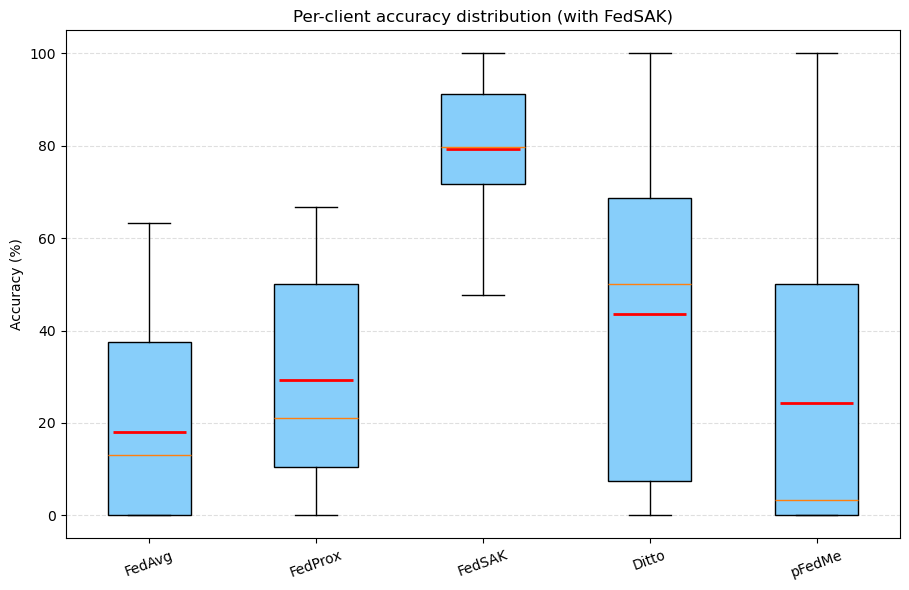

In [18]:
# Compare multiple methods (include FedSAK): multi-boxplot with per-box mean line
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

workspace_root = "/home/liruobin/FL/FederatedScope"

# Candidate log files from the notebook header (now include FedSAK)
log_paths = [
    # "exp/local_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820014230/eval_results.log",
    "exp/FedAvg_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806101050/eval_results.log",
    "exp/fedprox_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/eval_results.log",
    "exp/fedsak_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250820120543/eval_results.log",
    "exp/ditto_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250820123152/eval_results.log",
    "exp/pfedme_rnn_on_ut_har_frequency_domains_lr0.0005_lstep5/sub_exp_20250806114835/eval_results.log",
    # "exp/fedbn_cross_domain_digit_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
    # "exp/fdse_fdse_cnn_on_digits_lr0.001_lstep1/sub_exp_20250820013357/eval_results.log",
]

# Helper: resolve path

def resolve_path(p):
    if os.path.exists(p):
        return p
    ap = os.path.join(workspace_root, p)
    return ap if os.path.exists(ap) else None

# Helper: label from path

def label_from_path(p):
    # pick the first folder under exp/ as method label
    m = re.search(r"exp/([^/_]+)", p)
    if m:
        label = m.group(1)
    else:
        # fallback to folder name
        label = os.path.basename(os.path.dirname(p))
    # normalize common names for readability
    alias = {
        'FedAvg': 'FedAvg',
        'fedprox': 'FedProx',
        'ditto': 'Ditto',
        'pfedme': 'pFedMe',
        'fedbn': 'FedBN',
        'local': 'Local',
        'fedsak': 'FedSAK',
        'fdse': 'Fdse'
    }
    # map by lowercase key if matched
    key = label.lower()
    for k, v in alias.items():
        if key == k:
            return v
    # Title-case fallback
    return label

# Helper: extract accuracy from a line

def extract_acc_from_line(line: str):
    try:
        obj = ast.literal_eval(line.strip())
        if isinstance(obj, dict):
            metrics = obj.get('Results_raw', obj)
        else:
            metrics = None
    except Exception:
        metrics = None
    if metrics is None:
        m = re.findall(r"['\"]([A-Za-z0-9_]*acc[A-Za-z0-9_]*)['\"]\s*:\s*([0-9]*\.?[0-9]+)", line, flags=re.IGNORECASE)
        if m:
            m_sorted = sorted(m, key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
            return float(m_sorted[0][1])
        return None
    acc_keys = []
    for k, v in metrics.items():
        if isinstance(v, (int, float)) and ("acc" in k.lower() or "accuracy" in k.lower()):
            acc_keys.append((k, float(v)))
    if not acc_keys:
        return None
    acc_keys.sort(key=lambda kv: (0 if kv[0].lower()=="test_acc" else 1, kv[0]))
    return acc_keys[0][1]

# Load all logs
method_labels = []
method_values = []  # list of np.array (percent values)

for rel in log_paths:
    rp = resolve_path(rel)
    if rp is None:
        print(f"Skip (not found): {rel}")
        continue
    vals = []
    with open(rp, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            v = extract_acc_from_line(line)
            if v is not None:
                vals.append(v)
    if len(vals) == 0:
        print(f"Skip (no acc parsed): {rel}")
        continue
    arr = np.array(vals, dtype=float)
    # unify to percent for plotting
    arr = arr if arr.max() > 1.5 else arr * 100.0
    method_labels.append(label_from_path(rel))
    method_values.append(arr)

if len(method_values) == 0:
    raise RuntimeError("No valid logs found to plot.")

# Plot multi-boxplot
plt.figure(figsize=(1.2 + 1.6*len(method_values), 6))
positions = np.arange(1, len(method_values)+1)
plt.boxplot(method_values, positions=positions, widths=0.5, vert=True,
            patch_artist=True, boxprops=dict(facecolor='#87CEFA'))
plt.ylabel("Accuracy (%)")
plt.title("Per-client accuracy distribution (with FedSAK)")
plt.xticks(positions, method_labels, rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Draw a red mean line inside each box
for x, arr in zip(positions, method_values):
    mean_val = float(arr.mean())
    plt.hlines(mean_val, x-0.22, x+0.22, colors='red', linewidth=2)

plt.tight_layout()
plt.show()


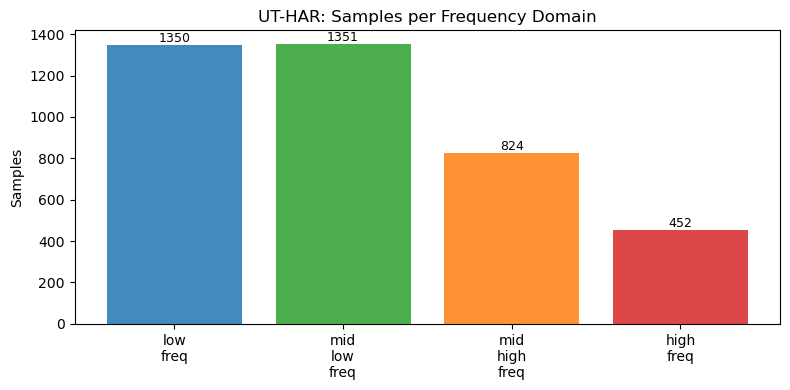

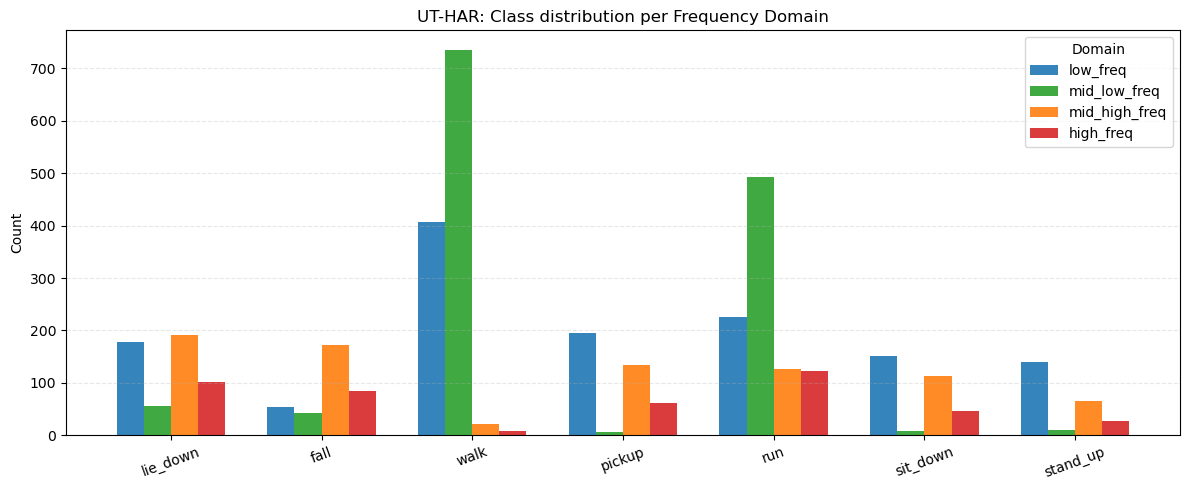

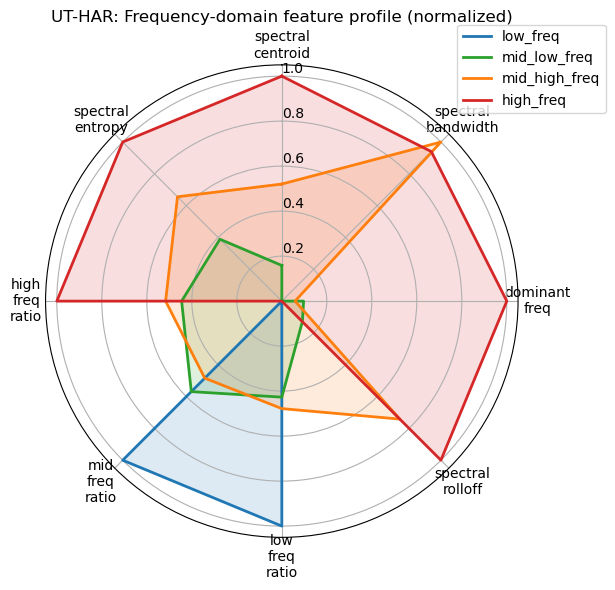

In [15]:
# Visualize UT-HAR frequency domains (overview + per-domain radar and bars)
import os, json
import numpy as np
import matplotlib.pyplot as plt
from math import pi

base = "/home/liruobin/FL/FederatedScope/data/ut_har_frequency_domains"
overview_fp = os.path.join(base, 'frequency_domains_overview.json')

# Load overview
with open(overview_fp, 'r', encoding='utf-8') as f:
    overview = json.load(f)

freq_domains = ['low_freq', 'mid_low_freq', 'mid_high_freq', 'high_freq']
colors = {
    'low_freq': '#1f77b4',
    'mid_low_freq': '#2ca02c',
    'mid_high_freq': '#ff7f0e',
    'high_freq': '#d62728'
}

# 1) Overview bar: sample_count per domain
counts = []
for d in freq_domains:
    counts.append(overview['frequency_domains'][d]['sample_count'])

plt.figure(figsize=(8,4))
xs = np.arange(len(freq_domains))
plt.bar(xs, counts, color=[colors[d] for d in freq_domains], alpha=0.85)
plt.xticks(xs, [d.replace('_','\n') for d in freq_domains])
plt.ylabel('Samples')
plt.title('UT-HAR: Samples per Frequency Domain')
for x, c in zip(xs, counts):
    plt.text(x, c, str(c), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 2) Class distribution per domain (stacked bar)
class_names = overview['class_names']
width = 0.18
fig, ax = plt.subplots(figsize=(12,5))

def get_domain_classes(d):
    return overview['frequency_domains'][d]['class_distribution']

max_class_len = len(class_names)
for i, d in enumerate(freq_domains):
    vals = np.array(get_domain_classes(d), dtype=int)
    ax.bar(np.arange(max_class_len)+i*width, vals, width=width, label=d, color=colors[d], alpha=0.9)

ax.set_xticks(np.arange(max_class_len) + width*(len(freq_domains)-1)/2)
ax.set_xticklabels(class_names, rotation=20)
ax.set_ylabel('Count')
ax.set_title('UT-HAR: Class distribution per Frequency Domain')
ax.legend(title='Domain')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Radar chart of domain cluster_center features
feature_names = None
radar_data = []  # list of (domain, values)

# Collect features and min/max for normalization
all_vals = []
per_domain_vals = {}
for d in freq_domains:
    info_fp = os.path.join(base, d, 'domain_info.json')
    with open(info_fp, 'r', encoding='utf-8') as f:
        info = json.load(f)
    if feature_names is None:
        feature_names = info['feature_names']
    vals = np.array(info['cluster_center'], dtype=float)
    radar_data.append((d, vals))
    per_domain_vals[d] = vals
    all_vals.append(vals)

all_vals = np.vstack(all_vals)
mins = all_vals.min(axis=0)
maxs = all_vals.max(axis=0)
# avoid division by zero
range_span = np.where(maxs - mins == 0, 1.0, maxs - mins)

# Prepare radar
N = len(feature_names)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels([fn.replace('_','\n') for fn in feature_names])
ax.set_rlabel_position(0)

for d, vals in radar_data:
    norm = (vals - mins) / range_span
    data = np.concatenate([norm, norm[:1]])
    ax.plot(angles, data, linewidth=2, linestyle='-', color=colors[d], label=d)
    ax.fill(angles, data, color=colors[d], alpha=0.15)

plt.title('UT-HAR: Frequency-domain feature profile (normalized)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

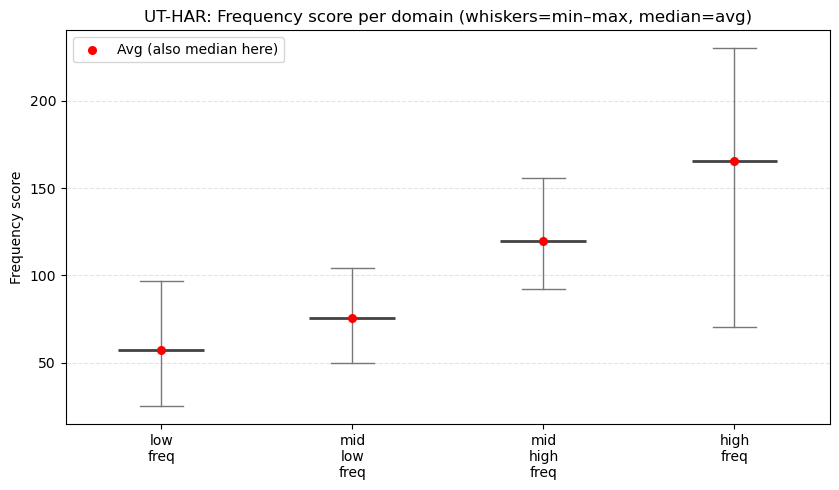

In [16]:
# Boxplot for UT-HAR frequency domains: whiskers=min/max, median=avg_frequency_score
import os, json
import numpy as np
import matplotlib.pyplot as plt

overview_fp = "/home/liruobin/FL/FederatedScope/data/ut_har_frequency_domains/frequency_domains_overview.json"
with open(overview_fp, 'r', encoding='utf-8') as f:
    overview = json.load(f)

domains = ['low_freq', 'mid_low_freq', 'mid_high_freq', 'high_freq']
colors = {
    'low_freq': '#1f77b4',
    'mid_low_freq': '#2ca02c',
    'mid_high_freq': '#ff7f0e',
    'high_freq': '#d62728',
}

stats = []
means = []
for d in domains:
    dom = overview['frequency_domains'][d]
    avg = float(dom['avg_frequency_score'])
    lo, hi = map(float, dom['freq_score_range'])
    stats.append({
        'label': d.replace('_', '\n'),
        'med': avg,  # 用平均值充当中位线以便显示
        'q1': avg,
        'q3': avg,
        'whislo': lo,
        'whishi': hi,
        'fliers': []
    })
    means.append(avg)

fig, ax = plt.subplots(figsize=(8.5, 5))
res = ax.bxp(stats, showfliers=False, patch_artist=True)

# Color each box
for box, d in zip(res['boxes'], domains):
    box.set_facecolor(colors[d])
    box.set_alpha(0.25)
for med in res['medians']:
    med.set_color('#444444')
    med.set_linewidth(2.0)
for whisk in res['whiskers']:
    whisk.set_color('#777777')
for cap in res['caps']:
    cap.set_color('#777777')

# Scatter mean markers (coincide with median line here)
xs = np.arange(1, len(domains)+1)
ax.scatter(xs, means, color='red', s=30, zorder=5, label='Avg (also median here)')

ax.set_ylabel('Frequency score')
ax.set_title('UT-HAR: Frequency score per domain (whiskers=min–max, median=avg)')
ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.legend(loc='best')
plt.tight_layout()
plt.show()